In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Chest_Xrays'

In [ ]:
# Define your data_transforms here
data_transforms = {
    'train': transforms.Compose([
        # Example: Resize the images, convert them to tensor, and normalize
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
# Load datasets
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                    data_transforms[x])
            for x in ['train', 'test']}

In [ ]:
#Define Train and test
dataloaders = {x: torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}

In [ ]:
dataset_sizes = {x: len(Datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

{'train': 5235, 'test': 624}


In [ ]:
class_names = Datasets['train'].classes
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
# Initialize counters for train and test sets
train_label_counts = {class_name: 0 for class_name in class_names}
test_label_counts = {class_name: 0 for class_name in class_names}

In [ ]:
train_path = '/content/drive/My Drive/Chest_Xrays/train'
training_generator = ImageDataGenerator(rescale= 1/255)
data_train = training_generator.flow_from_directory(train_path, target_size = (120,120), batch_size=8, class_mode='binary')
test_path = '/content/drive/My Drive/Chest_Xrays/test'
test_generator = ImageDataGenerator(rescale= 1/255)
data_test = training_generator.flow_from_directory(test_path, target_size = (120,120), batch_size=8, class_mode='binary')
val_path = '/content/drive/My Drive/Chest_Xrays/val'
val_generator = ImageDataGenerator(rescale= 1/255)
data_val = val_generator.flow_from_directory(val_path, target_size = (120,120), batch_size=8, class_mode='binary')

Found 5235 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
normal_images = [img for img in os.listdir(f'{train_path}/NORMAL')]
pneumonia_images = [img for img in os.listdir(f'{train_path}/PNEUMONIA')]

In [ ]:
# Randomly select a few images from the set to view
normal_select = np.random.choice(normal_images, 5, replace=False)
pneumonia_select = np.random.choice(pneumonia_images, 5, replace=False)

# Define a common size for all images
common_size = (224, 224)

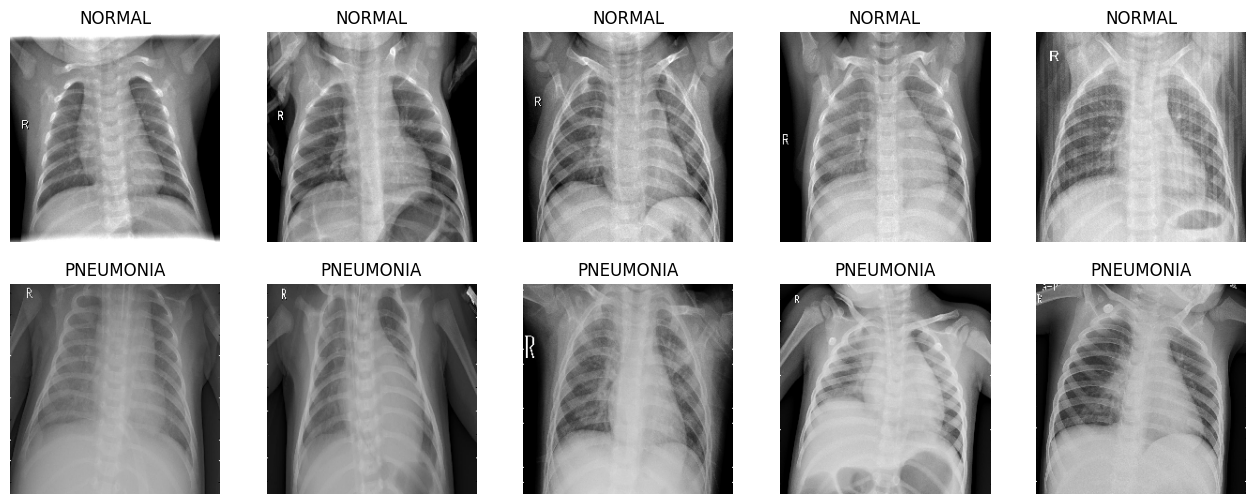

In [ ]:
fig = plt.figure(figsize=(16, 6))  # Adjusted figure size for better fit

# Iterate over the selected images
for i in range(10):
    if i < 5:
        fpath = f'{train_path}/NORMAL/{normal_select[i]}'
        label = 'NORMAL'
    else:
        fpath = f'{train_path}/PNEUMONIA/{pneumonia_select[i-5]}'
        label = 'PNEUMONIA'

    ax = fig.add_subplot(2, 5, i+1)

    # Load image with the same size
    im = image.load_img(fpath, target_size=(224, 224))
    plt.imshow(im)
    plt.title(label)
    plt.axis('off')


In [ ]:
#Generate an average image for each class from the the above classes of images
#This will help understand the general characteristics of each class

def img_to_matrix(fpath, flist, size=(64,64)):
    for fname in flist:
        full_path = fpath+fname
        current_image = image.load_img(full_path, target_size = size, color_mode = 'grayscale')

        #convert image to 64 x 64 matrix
        img_mat1 = image.img_to_array(current_image)
        img_mat1 = [img_mat1.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_mat1))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_mat1
    return full_mat



In [ ]:
normal_images1 = img_to_matrix(f'{train_path}/NORMAL/', normal_images)
pneumonia_images1 = img_to_matrix(f'{train_path}/PNEUMONIA/', pneumonia_images)

In [ ]:
def mean_img(full_mat, title, size=(64,64)):
    mean_image = np.mean(full_mat, axis=0)
    mean_image = mean_image.reshape(size)
    plt.imshow(mean_image, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_image

def variance_img(full_mat, title, size=(64,64)):
    var_image = np.std(full_mat, axis=0)
    var_image = var_image.reshape(size)
    plt.imshow(var_image, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return var_image

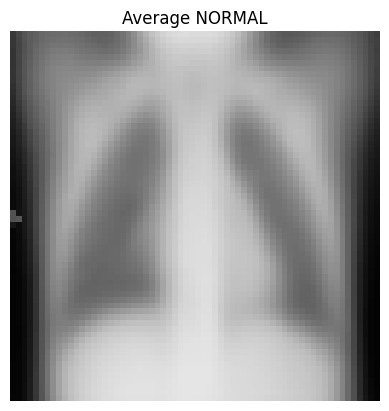

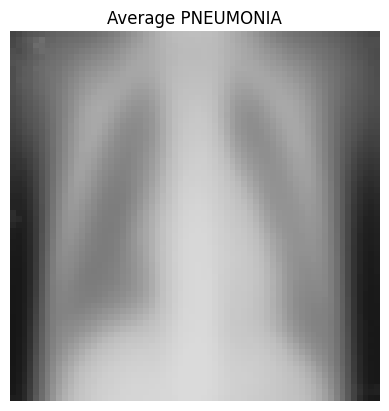

In [ ]:
#View Mean Image
normal_mean = mean_img(normal_images1, 'NORMAL')
pneumonia_mean = mean_img(pneumonia_images1, 'PNEUMONIA')

#It can be seen that image is obstructed in case of pneumonia

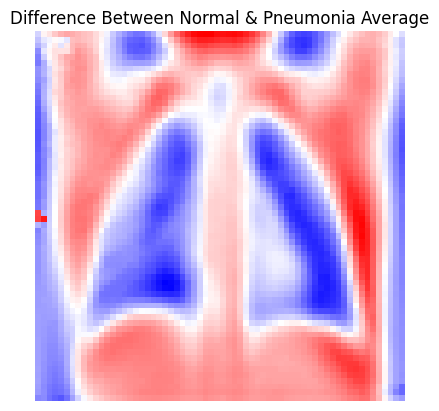

In [ ]:
#Generate a contrasting image
contrast_mean = normal_mean - pneumonia_mean

plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

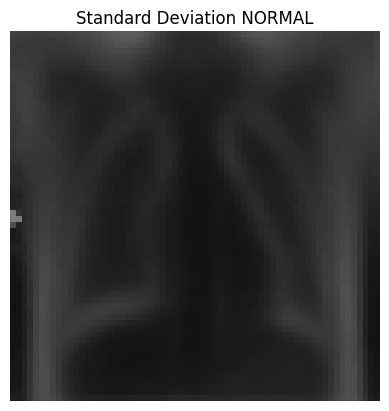

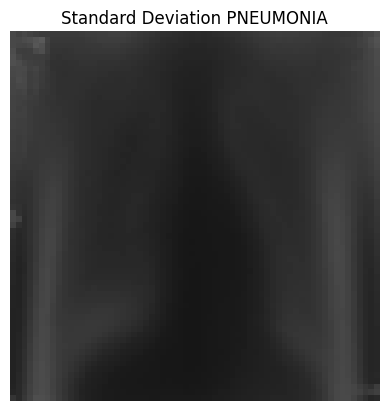

In [ ]:
#We can check the variability within the lungs
normal_var = variance_img(normal_images1, 'NORMAL')
pneumonia_var = variance_img(pneumonia_images1, 'PNEUMONIA')

#Lighter area indicates higher variability
#It can be seen that variability is more in case of pneumonia

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(120, 120, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Changed activation function to 'sigmoid'
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 128)       0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss= "binary_crossentropy", metrics= ["accuracy"])

In [ ]:
# Define the early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # To display messages when the callback takes action
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [ ]:
history = model.fit(data_train, epochs=10, validation_data=data_val,callbacks=[early_stopping_callback])

Epoch 1/10
655/655 [==============================] - 269s 406ms/step - loss: 0.3874 - accuracy: 0.8235 - val_loss: 0.4414 - val_accuracy: 0.8750
Epoch 2/10
655/655 [==============================] - 263s 401ms/step - loss: 0.1722 - accuracy: 0.9337 - val_loss: 0.3726 - val_accuracy: 0.8125
Epoch 3/10
655/655 [==============================] - 311s 474ms/step - loss: 0.1222 - accuracy: 0.9513 - val_loss: 0.7468 - val_accuracy: 0.6875
Epoch 4/10
655/655 [==============================] - 290s 443ms/step - loss: 0.0914 - accuracy: 0.9662 - val_loss: 0.2284 - val_accuracy: 0.9375
Epoch 5/10
655/655 [==============================] - 294s 448ms/step - loss: 0.0762 - accuracy: 0.9713 - val_loss: 0.6464 - val_accuracy: 0.6875
Epoch 6/10
655/655 [==============================] - 257s 393ms/step - loss: 0.0701 - accuracy: 0.9752 - val_loss: 0.6232 - val_accuracy: 0.7500
Epoch 7/10
655/655 [==============================] - 286s 436ms/step - loss: 0.0618 - accuracy: 0.9731 - val_loss: 0.3012 -

In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/model_with_attention.h5', '/content/')
shutil.copy('/content/drive/MyDrive/my_denseNet_model.h5', '/content/')
shutil.copy('/content/drive/MyDrive/my_cnn_model (1).h5', '/content/')
shutil.copy('/content/drive/MyDrive/my_Vgg16_model.h5', '/content/')

'/content/my_Vgg16_model.h5'

In [ ]:
import tensorflow as tf

# Define the SimpleAttentionLayer class
class SimpleAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SimpleAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(SimpleAttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.dot(x, self.W)
        e = tf.keras.backend.squeeze(e, axis=-1)

        # Add an extra dimension to e before applying softmax
        e = tf.keras.backend.expand_dims(e, axis=-1)  # This line is added to ensure e is 2D

        alpha = tf.keras.backend.softmax(e, axis=-1)
        alpha = tf.keras.backend.squeeze(alpha, axis=-1)  # Squeeze back to original shape after softmax if needed
        context = x * tf.keras.backend.expand_dims(alpha, axis=-1)
        return context

    def compute_output_shape(self, input_shape):
        return input_shape

# Load the model with a custom object scope
with tf.keras.utils.custom_object_scope({'SimpleAttentionLayer': SimpleAttentionLayer}):
    model_with_attention = tf.keras.models.load_model('/content/model_with_attention.h5')


In [ ]:
import tensorflow as tf
cnn_model = tf.keras.models.load_model('/content/my_cnn_model (1).h5')
VGG16_model = tf.keras.models.load_model('/content/my_Vgg16_model.h5')
denseNet_model = tf.keras.models.load_model('/content/my_denseNet_model.h5')
#model_with_attention = tf.keras.models.load_model('/content/model_with_attention.h5')

In [ ]:
cnn_model.evaluate(data_test)

78/78 [==============================] - 121s 2s/step - loss: 0.4759 - accuracy: 0.8189


[0.47593122720718384, 0.8189102411270142]

In [ ]:
VGG16_model.evaluate(data_test)

78/78 [==============================] - 10s 101ms/step - loss: 18.7724 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00


[18.772443771362305, 0.375, 0.0, 0.0]

In [ ]:
denseNet_model.evaluate(data_test)

78/78 [==============================] - 12s 95ms/step - loss: 0.2790 - accuracy: 0.8958


[0.2789548337459564, 0.8958333134651184]

In [ ]:
model_with_attention.evaluate(data_test)

78/78 [==============================] - 182s 2s/step - loss: 2.4143 - accuracy: 0.7420


[2.4142909049987793, 0.7419871687889099]

In [ ]:
pred=model.predict(data_test)

78/78 [==============================] - 15s 190ms/step


In [ ]:
evaluation = model.evaluate(data_test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(data_train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

78/78 [==============================] - 14s 174ms/step - loss: 0.4759 - accuracy: 0.8189
Test Accuracy: 81.89%
655/655 [==============================] - 128s 195ms/step - loss: 0.0803 - accuracy: 0.9700
Train Accuracy: 97.00%


1/1 [==============================] - 0s 279ms/step


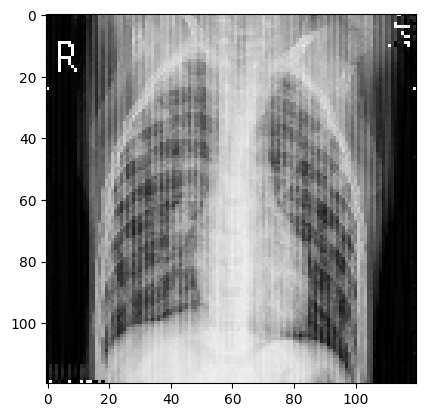

The probability of pneumonia is: [0.9984831]
The actual label is: 1.0


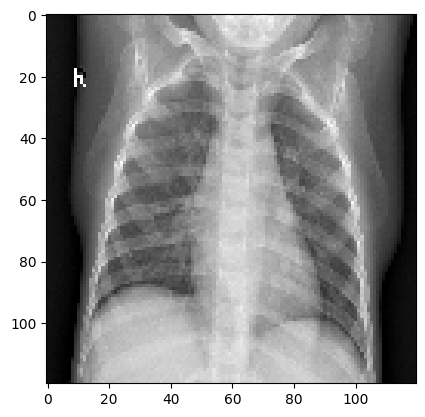

The probability of pneumonia is: [0.02983033]
The actual label is: 0.0


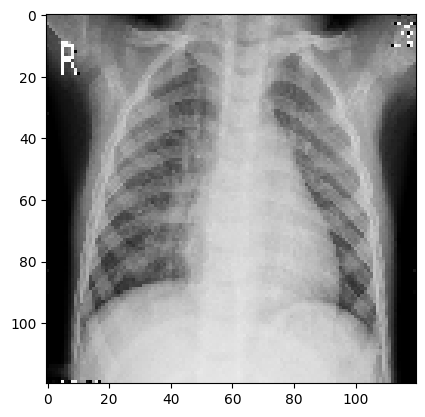

The probability of pneumonia is: [0.9970346]
The actual label is: 1.0


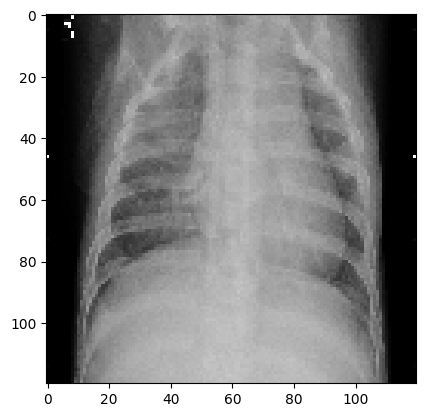

The probability of pneumonia is: [0.9953879]
The actual label is: 1.0


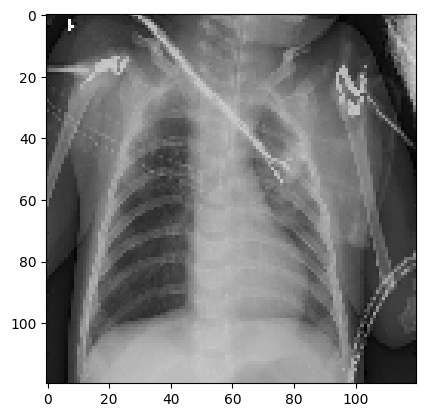

The probability of pneumonia is: [0.35623232]
The actual label is: 1.0


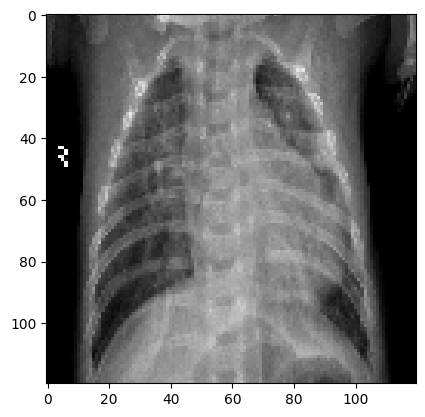

The probability of pneumonia is: [0.9891578]
The actual label is: 1.0


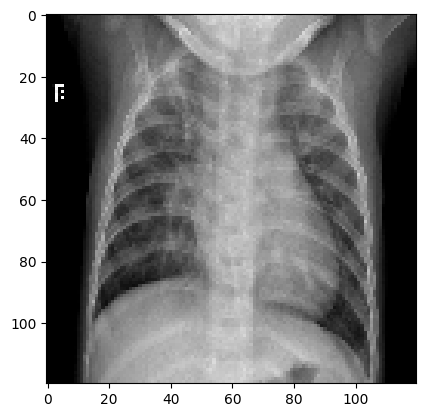

The probability of pneumonia is: [0.8628582]
The actual label is: 1.0


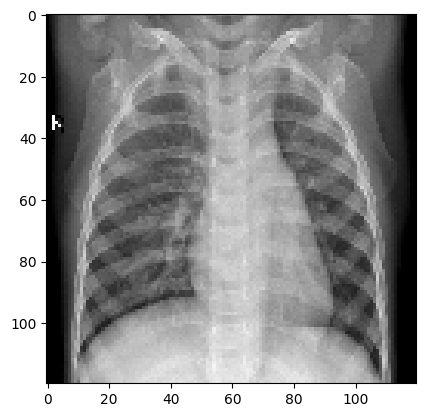

The probability of pneumonia is: [0.95155895]
The actual label is: 0.0


In [ ]:
# Display images from the test data generator
for _ in range(1):  # Iterate over a single batch
    x, y_true = next(data_test)  # Get a batch of images and their labels
    pred = model.predict(x)  # Predict probabilities for the images
    for j in range(x.shape[0]):  # Iterate over the batch size
        plt.imshow(x[j])
        plt.show()
        print("The probability of pneumonia is:", pred[j])
        print("The actual label is:", y_true[j])

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras import backend as K
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.layers import Dense, GlobalAveragePooling2D

num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 186, 186, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 90, 90, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
num_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))

In [ ]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [ ]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [ ]:
#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

base_model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

base_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
r = base_model.fit(
    data_train,
    epochs=5,
    validation_data=data_val,
    class_weight=class_weight,
    steps_per_epoch=60,
    validation_steps=10,
)


Epoch 1/5
60/60 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.8417

60/60 [==============================] - 152s 2s/step - loss: 0.1837 - accuracy: 0.8417 - val_loss: 71.5190 - val_accuracy: 0.5000
Epoch 2/5
60/60 [==============================] - 105s 2s/step - loss: 0.0879 - accuracy: 0.9062
Epoch 3/5
60/60 [==============================] - 105s 2s/step - loss: 0.0712 - accuracy: 0.9125
Epoch 4/5
60/60 [==============================] - 106s 2s/step - loss: 0.1201 - accuracy: 0.8854
Epoch 5/5
60/60 [==============================] - 107s 2s/step - loss: 0.0717 - accuracy: 0.9354


In [ ]:
evaluation = base_model.evaluate(data_test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = base_model.evaluate(data_train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

78/78 [==============================] - 45s 581ms/step - loss: 0.8336 - accuracy: 0.7196
Test Accuracy: 71.96%
655/655 [==============================] - 310s 473ms/step - loss: 0.2649 - accuracy: 0.8766
Train Accuracy: 87.66%


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16


vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')
vgg16_base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [ ]:
vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

model = Sequential()
model.add(vgg16_model.layers[0])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
vgg16_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

In [ ]:
r = vgg16_model.fit(data_train,
          epochs=5,
          validation_data=data_val,
          class_weight=class_weight,
          steps_per_epoch=60,
          validation_steps=10)

Epoch 1/5
60/60 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.5583 - precision: 0.8159 - recall: 0.5372

60/60 [==============================] - 340s 6s/step - loss: 0.2776 - accuracy: 0.5583 - precision: 0.8159 - recall: 0.5372 - val_loss: 59.3217 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
60/60 [==============================] - 330s 6s/step - loss: 0.1985 - accuracy: 0.7474 - precision: 0.9184 - recall: 0.6923
Epoch 3/5
60/60 [==============================] - 319s 5s/step - loss: 0.1675 - accuracy: 0.7667 - precision: 0.9434 - recall: 0.7205
Epoch 4/5
60/60 [==============================] - 319s 5s/step - loss: 0.1581 - accuracy: 0.7937 - precision: 0.9647 - recall: 0.7541
Epoch 5/5
60/60 [==============================] - 321s 5s/step - loss: 0.1621 - accuracy: 0.8042 - precision: 0.9281 - recall: 0.7878


In [ ]:
evaluation =vgg16_model.evaluate(data_test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(data_train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

78/78 [==============================] - 116s 1s/step - loss: 12.8333 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Test Accuracy: 62.50%
655/655 [==============================] - 967s 1s/step - loss: 8.5942 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000
Train Accuracy: 74.38%


In [ ]:
model_mae_scores_dict = {'CNN': 81.89,'DenseNet' : 89.58, 'VGG16' : 37.50, 'HybridCNN' : 74.20}

In [ ]:
import pandas as pd

In [ ]:
model_mae_scores

CNN          81.89
DenseNet     89.58
VGG16        37.50
HybridCNN    74.20
dtype: float64

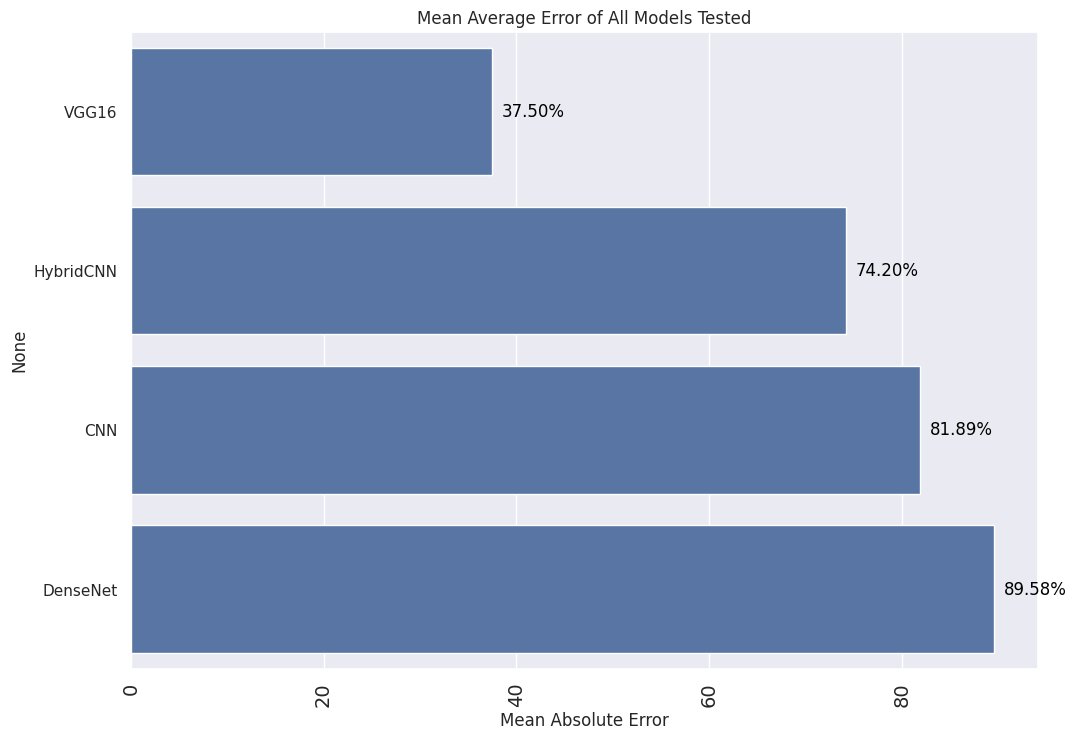

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

model_mae_scores_dict = {'CNN': 81.89,'DenseNet' : 89.58, 'VGG16' : 37.50, 'HybridCNN' : 74.20}

model_mae_scores = pd.Series(model_mae_scores_dict)
order = model_mae_scores.sort_values()

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(x=order.values, y=order.index, orient='h')

plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical', fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# Add percentage labels to the end of each bar
for i, v in enumerate(order.values):
    plt.text(v + 1, i, '{:.2f}%'.format(v), color='black', va='center')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])


In [ ]:
history = model.fit(data_train, epochs=10, validation_data=data_val)

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

class SimpleAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SimpleAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        super(SimpleAttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.dot(x, self.W)
        e = tf.keras.backend.squeeze(e, axis=-1)

        # Add an extra dimension to e before applying softmax
        e = tf.keras.backend.expand_dims(e, axis=-1)  # This line is added to ensure e is 2D

        alpha = tf.keras.backend.softmax(e, axis=-1)
        alpha = tf.keras.backend.squeeze(alpha, axis=-1)  # Squeeze back to original shape after softmax if needed
        context = x * tf.keras.backend.expand_dims(alpha, axis=-1)
        return context

    def compute_output_shape(self, input_shape):
        return input_shape



In [ ]:
model_with_attention = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    SimpleAttentionLayer(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model_with_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_with_attention.fit(data_train, epochs=10, validation_data=data_val,)

Epoch 1/10
655/655 [==============================] - 586s 891ms/step - loss: 0.1912 - accuracy: 0.9251 - val_loss: 0.2201 - val_accuracy: 0.8750
Epoch 2/10
655/655 [==============================] - 63s 96ms/step - loss: 0.1127 - accuracy: 0.9587 - val_loss: 0.3469 - val_accuracy: 0.8125
Epoch 3/10
655/655 [==============================] - 63s 96ms/step - loss: 0.0851 - accuracy: 0.9692 - val_loss: 0.7911 - val_accuracy: 0.6875
Epoch 4/10
655/655 [==============================] - 63s 96ms/step - loss: 0.0690 - accuracy: 0.9727 - val_loss: 0.1463 - val_accuracy: 0.9375
Epoch 5/10
655/655 [==============================] - 63s 96ms/step - loss: 0.0491 - accuracy: 0.9822 - val_loss: 0.0859 - val_accuracy: 1.0000
Epoch 6/10
655/655 [==============================] - 63s 96ms/step - loss: 0.0483 - accuracy: 0.9834 - val_loss: 0.4617 - val_accuracy: 0.8750
Epoch 7/10
655/655 [==============================] - 63s 96ms/step - loss: 0.0330 - accuracy: 0.9903 - val_loss: 0.5605 - val_accurac

78/78 [==============================] - 244s 3s/step - loss: 2.4143 - accuracy: 0.7420


[2.4142909049987793, 0.7419871687889099]

In [ ]:
model_with_attention.save('/content/model_with_attention.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
